In [1]:
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
from keras.utils import to_categorical
import numpy as np
import os

Using TensorFlow backend.


In [2]:
# Training parameters
batch_size = 32
epochs = 100
num_classes = 10

In [3]:
# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 6s 0us/step


In [4]:
# Input image dimensions.
input_shape = x_train.shape[1:]
input_shape

(32, 32, 3)

In [5]:
# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [6]:
# Subtracting pixel mean improves accuracy
x_train_mean = np.mean(x_train, axis=0)
x_train -= x_train_mean
x_test -= x_train_mean

In [7]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


In [8]:
# Convert class vectors to binary class matrices.
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [9]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [10]:
n = 3
depth = n * 6 + 2

In [11]:
def resnet(input_shape, depth, num_classes=10):
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [12]:
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 80:
        lr *= 1e-1
    return lr

# Compile the Model

In [13]:
model = resnet(input_shape=input_shape, depth=depth)
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr_schedule(0)),
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [15]:
# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'ResNet'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

In [16]:
# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

# Train the Model

In [17]:
h=model.fit(x_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(x_test, y_test),
            shuffle=True,
            callbacks=callbacks)

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 69s 1ms/step - loss: 1.4729 - accuracy: 0.5250 - val_loss: 1.3163 - val_accuracy: 0.5855
Epoch 2/100
  160/50000 [..............................] - ETA: 53s - loss: 1.1268 - accuracy: 0.6625

/opt/conda/lib/python3.7/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


50000/50000 [==============================] - 59s 1ms/step - loss: 1.0684 - accuracy: 0.6791 - val_loss: 1.2016 - val_accuracy: 0.6414
Epoch 3/100
50000/50000 [==============================] - 59s 1ms/step - loss: 0.9154 - accuracy: 0.7379 - val_loss: 0.9792 - val_accuracy: 0.7230
Epoch 4/100
50000/50000 [==============================] - 58s 1ms/step - loss: 0.8142 - accuracy: 0.7744 - val_loss: 1.0837 - val_accuracy: 0.7006
Epoch 5/100
50000/50000 [==============================] - 59s 1ms/step - loss: 0.7411 - accuracy: 0.8026 - val_loss: 1.1677 - val_accuracy: 0.6743
Epoch 6/100
50000/50000 [==============================] - 59s 1ms/step - loss: 0.6936 - accuracy: 0.8190 - val_loss: 0.9900 - val_accuracy: 0.7347
Epoch 7/100
50000/50000 [==============================] - 59s 1ms/step - loss: 0.6497 - accuracy: 0.8388 - val_loss: 1.1244 - val_accuracy: 0.7063
Epoch 8/100
50000/50000 [==============================] - 58s 1ms/step - loss: 0.6197 - accuracy: 0.8484 - val_loss: 1.1826

# Loss

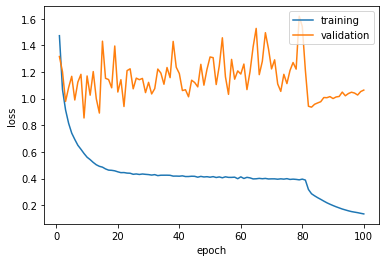

In [22]:
import matplotlib.pyplot as plt
epoch_nums = range(1, epochs+1)
training_loss = h.history["loss"]
validation_loss = h.history["val_loss"]
plt.plot(epoch_nums , training_loss)
plt.plot(epoch_nums , validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training','validation'], loc='upper right')
plt.show()

# Trained Model Score

In [23]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 3s 282us/step
Test loss: 1.0642930257320404
Test accuracy: 0.8320000171661377


# Trained Model Test

In [20]:
def testImage(result):
    print(result) 
    if result[0][0]==1: 
        print("Aeroplane") 
    elif result[0][1]==1: 
        print('Automobile') 
    elif result[0][2]==1: 
        print('Bird') 
    elif result[0][3]==1: 
        print('Cat') 
    elif result[0][4]==1: 
        print('Deer') 
    elif result[0][5]==1: 
        print('Dog') 
    elif result[0][6]==1: 
        print('Frog') 
    elif result[0][7]==1: 
        print('Horse') 
    elif result[0][8]==1: 
        print('Ship') 
    elif result[0][9]==1: 
        print('Truck') 
    else:
        print('Error')

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
Automobile


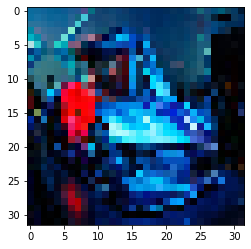

In [36]:
from keras.preprocessing import image

test_image1 =image.load_img("../input/imagetest/Image/automobile2.jpg",target_size =(32,32,3))
test_image =image.img_to_array(test_image1) 
test_image =np.expand_dims(test_image, axis =0) 
result = model.predict(test_image)
plt.imshow(test_image1)
testImage(result)

[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
Horse


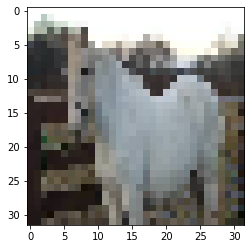

In [45]:
test_image2 =image.load_img("../input/imagetest/Image/horse2.jpg",target_size =(32,32,3))
test_img2 =image.img_to_array(test_image2) 
test_img2 =np.expand_dims(test_img2, axis =0) 
result = model.predict(test_img2)
plt.imshow(test_image2)
testImage(result)

# Test by Dataset

In [54]:
y_pred_test = model.predict(x_test)
y_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)

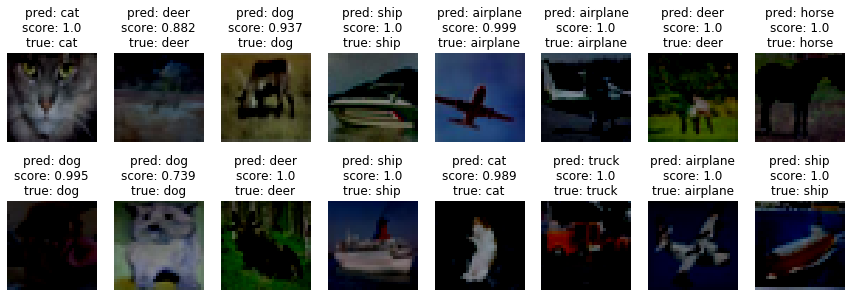

In [55]:
cols = 8
rows = 2
NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        y_test = y_test.astype(int)
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_test[random_index, :])
        pred_label =  cifar10_classes[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = cifar10_classes[y_test_classes[random_index]]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
               pred_label, pred_proba, true_label
        ))
plt.show()